## Intro

There is a database with following tables:
- user_data - contains data about users
- post_text_df - contains data about posts
- feed_data - contains data about users interaction with posts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Database connection URI
import os
from dotenv import load_dotenv

load_dotenv()
conn_uri = os.environ['DATABASE_URI']

In [4]:
# Users data

pd.read_sql(
    '''
    SELECT * FROM public.user_data
    ''',
    con=conn_uri
)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [5]:
# Posts data

pd.read_sql(
    '''
    SELECT * FROM public.post_text_df
    ''',
    con=conn_uri
)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [6]:
# Feed data

pd.read_sql(
    '''
    SELECT * FROM public.feed_data LIMIT 5
    ''',
    con=conn_uri
)

,timestamp,user_id,post_id,action,target
0,2021-11-09 13:24:14,23495,2729,view,0
1,2021-11-09 13:25:26,23495,5201,view,0
2,2021-11-09 13:25:56,23495,3774,view,0
3,2021-11-09 13:26:35,23495,1304,view,0
4,2021-11-09 13:28:40,23495,6140,view,0


In [7]:
pd.read_sql(
    '''
    SELECT count(*) FROM public.feed_data
    ''',
    con=conn_uri
)

,count
0,76892800


77 million entries dataset is too large to fit on regular RAM. One way to solve this is to sample the feed data.

In [9]:
data = pd.read_sql(
    '''
    SELECT
        public.feed_data.timestamp,
        public.feed_data.user_id,
        public.feed_data.post_id,
        public.feed_data.target,
        public.post_text_df.text,
        public.post_text_df.topic,
        public.user_data.gender,
        public.user_data.age,
        public.user_data.country,
        public.user_data.city,
        public.user_data.exp_group,
        public.user_data.os,
        public.user_data.source
    FROM public.feed_data
    TABLESAMPLE BERNOULLI (0.5)
    INNER JOIN public.post_text_df
    ON public.feed_data.post_id=public.post_text_df.post_id
    INNER JOIN public.user_data
    ON public.feed_data.user_id=public.user_data.user_id
    ''',
    conn_uri
)

## EDA

In [10]:
data.describe()

,user_id,post_id,target,gender,age,exp_group
count,384257.000000,384257.000000,384257.000000,384257.000000,384257.000000,384257.000000
mean,85046.536014,3398.160351,0.107871,0.555571,27.210614,1.990244
std,48894.964348,2096.560587,0.310217,0.496903,10.240985,1.406362
min,200.000000,1.000000,0.000000,0.000000,14.000000,0.000000
25%,41251.000000,1528.000000,0.000000,0.000000,20.000000,1.000000
50%,85501.000000,3196.000000,0.000000,1.000000,24.000000,2.000000
75%,127566.000000,5206.000000,0.000000,1.000000,33.000000,3.000000
max,168552.000000,7319.000000,1.000000,1.000000,92.000000,4.000000


In [11]:
data.dtypes

timestamp    datetime64[ns]
user_id               int64
post_id               int64
target                int64
text                 object
topic                object
gender                int64
age                   int64
country              object
city                 object
exp_group             int64
os                   object
source               object
dtype: object

In [12]:
data.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
text         0
topic        0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
dtype: int64

In [13]:
# Extracting datetime features: date, month, day of week, hour

data['date'] = data.timestamp.dt.date
data['month'] = data.timestamp.dt.month
data['day_of_week'] = data.timestamp.dt.dayofweek
data['hour'] = data.timestamp.dt.hour

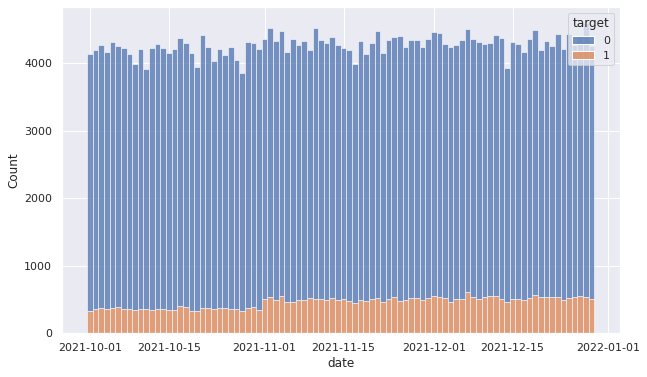

In [14]:
plt.figure(figsize=(10,6))
sns.set_theme()
sns.histplot(data=data, x='date', hue='target', multiple='stack');

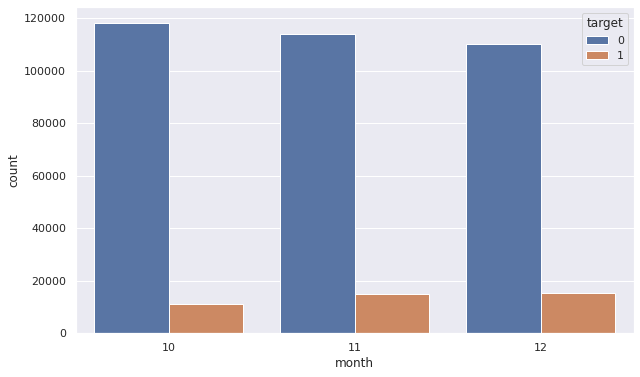

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='month', hue='target');

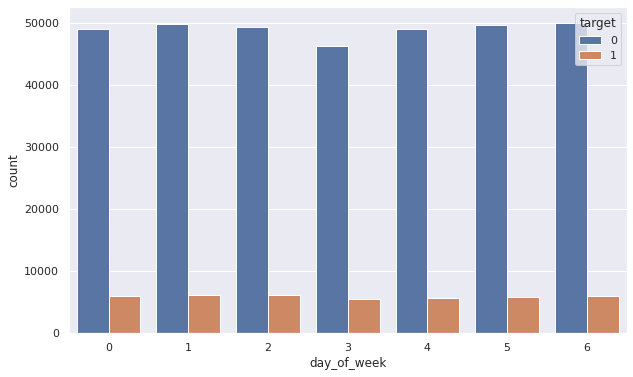

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='day_of_week', hue='target');

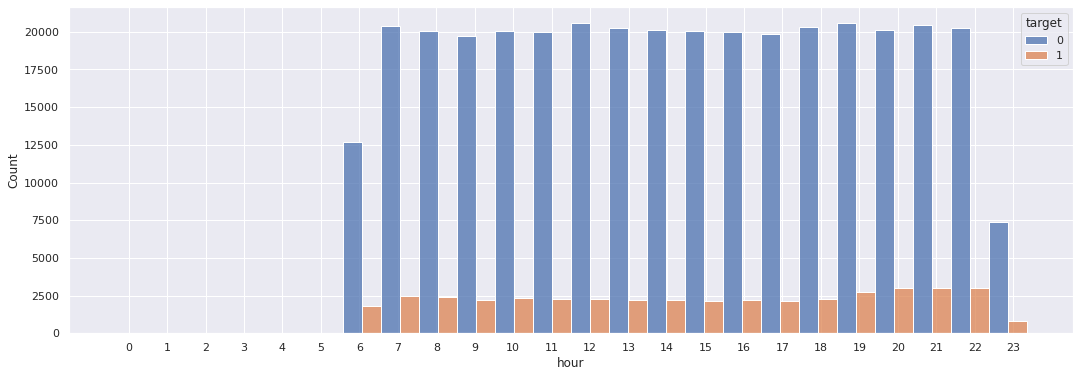

In [17]:
plt.figure(figsize=(18,6))
sns.histplot(data=data, x='hour', hue='target', multiple='dodge', shrink=4.0)
plt.xticks(range(0, 24));

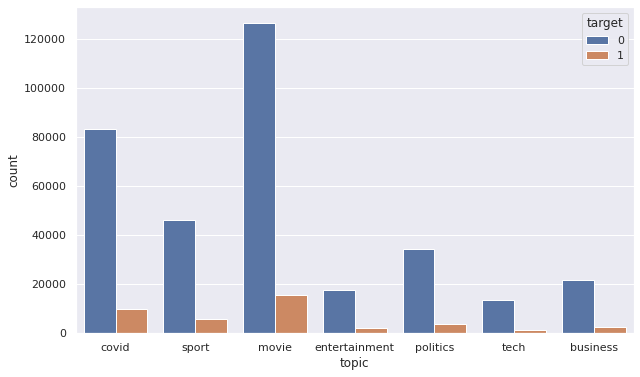

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='topic', hue='target');

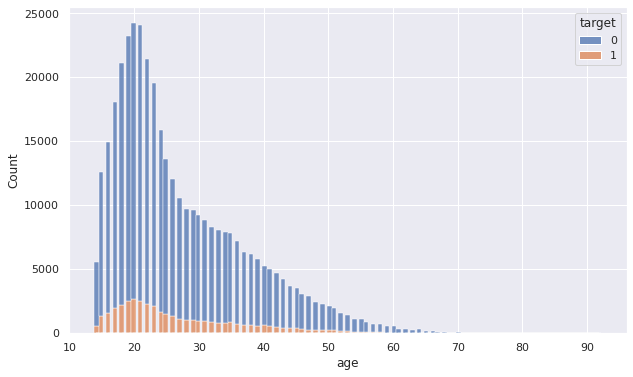

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='age', hue='target', multiple='stack', shrink=2.0);

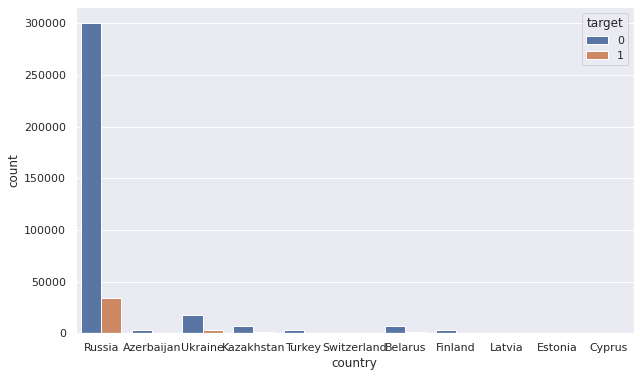

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='country', hue='target');

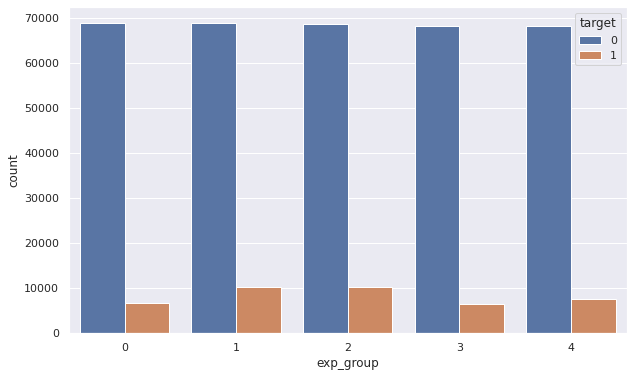

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='exp_group', hue='target');

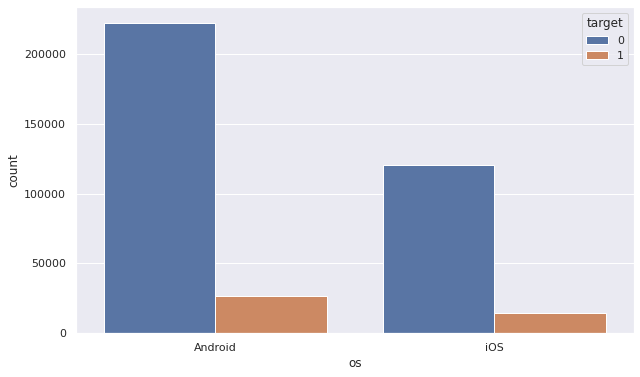

In [22]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='os', hue='target');

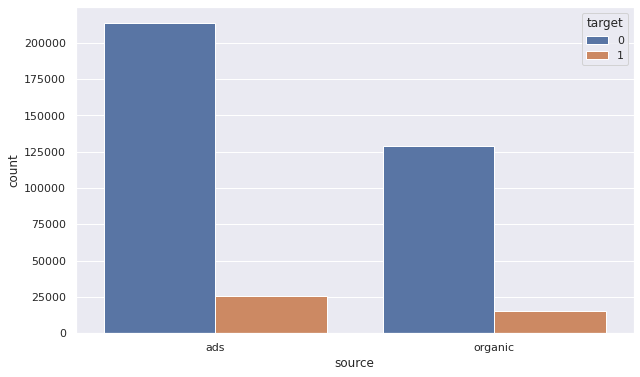

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='source', hue='target');

## Feature Engineering

#### Text encoding (TF-IDF)

In [24]:
df_posts = pd.read_sql(
    '''
    SELECT *
    FROM public.post_text_df
    ''',
    conn_uri
)
df_posts

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [25]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    return line

vectorizer = TfidfVectorizer(
    max_df=0.9, 
    min_df=0.003, 
    stop_words='english',
    preprocessor=preprocessing
)
tfidf_matrix = vectorizer.fit_transform(df_posts['text'])
tfidf_matrix

<7023x4880 sparse matrix of type '<class 'numpy.float64'>'
	with 464120 stored elements in Compressed Sparse Row format>

In [26]:
df_tfidf = df_posts.copy()
df_tfidf['tfidf_sum'] = pd.DataFrame(tfidf_matrix.todense()).sum(axis=1)
df_tfidf['tfidf_max'] = pd.DataFrame(tfidf_matrix.todense()).max(axis=1)
df_tfidf

,post_id,text,topic,tfidf_sum,tfidf_max
0,1,UK economy facing major risks\n\nThe UK manufa...,business,9.388155,0.301492
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,10.911074,0.219301
2,3,Asian quake hits European shares\n\nShares in ...,business,10.614318,0.349036
3,4,India power shares jump on debut\n\nShares in ...,business,6.704049,0.436909
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.589813,0.452052
...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,5.727741,0.322693
7019,7316,I give this movie 2 stars purely because of it...,movie,6.168378,0.267284
7020,7317,I cant believe this film was allowed to be mad...,movie,5.100407,0.362198
7021,7318,The version I saw of this film was the Blockbu...,movie,6.351284,0.284994


In [27]:
df_tfidf = df_tfidf.drop(['text'], axis=1)
data = data.drop(['topic'], axis=1)
data = data.join(df_tfidf.set_index('post_id'), on='post_id')

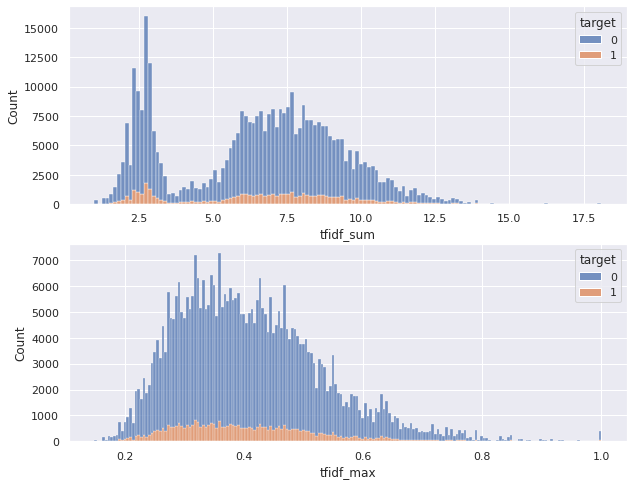

In [28]:
fig, axs = plt.subplots(nrows=2, figsize=(10,8))
sns.histplot(data=data, x='tfidf_sum', hue='target', multiple='stack', ax=axs[0])
sns.histplot(data=data, x='tfidf_max', hue='target', multiple='stack', ax=axs[1]);

#### Likes per user

In [29]:
# SQL request from database to make data available for all users.
# Timestamp condition is due to prevent data leakage. See below.

df_utl = pd.read_sql(
    '''
    SELECT user_id, COUNT(post_id) AS user_total_likes
    FROM public.feed_data
    WHERE timestamp < '2021-12-15 00:00:00' AND target = 1
    GROUP BY user_id
    ''',
    conn_uri
)
df_utl

,user_id,user_total_likes
0,200,37
1,201,46
2,202,69
3,203,43
4,204,13
...,...,...
163177,168548,18
163178,168549,21
163179,168550,37
163180,168551,43


In [30]:
data = pd.merge(data,
              df_utl,
              on='user_id',
              how='left')
data['user_total_likes'] = data['user_total_likes'].fillna(0).astype(int)

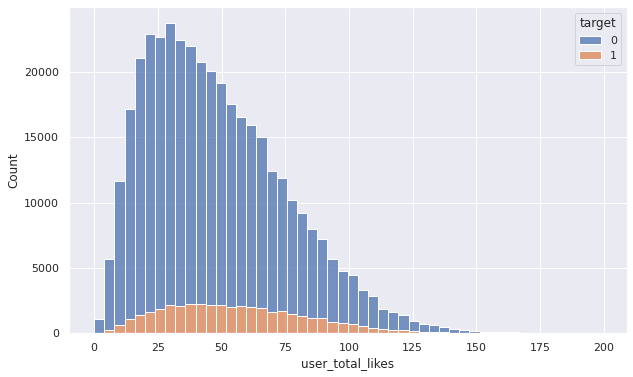

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='user_total_likes', hue='target', bins=50, multiple='stack');

## CatBoost baseline

In [32]:
# Dropping redundant columns

data = data.drop(['user_id', 'post_id', 'text', 'date'], axis=1)

In [33]:
# Since we have a time-series data, we can split train and test on a certain date.
# That way we test a model generalization ability for future prediction.

max(data.timestamp), min(data.timestamp)

(Timestamp('2021-12-29 23:38:54'), Timestamp('2021-10-01 06:02:01'))

In [34]:
# Let's split on 2021-12-15
# It should provide roughly an 80% to 20% ratio

data_train = data[data.timestamp < '2021-12-15']
data_test = data[data.timestamp >= '2021-12-15']

data_train = data_train.drop('timestamp', axis=1)
data_test = data_test.drop('timestamp', axis=1)

In [35]:
X_train = data_train.drop('target', axis=1)
X_test = data_test.drop('target', axis=1)

y_train = data_train['target']
y_test = data_test['target']

In [36]:
y_train.shape, y_test.shape

((319267,), (64990,))

In [37]:
from catboost import CatBoostClassifier

cat_cols = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'month', 'day_of_week', 'hour', 'topic']

model = CatBoostClassifier(
    loss_function='Logloss',
    cat_features=cat_cols,
    verbose=100
)

model.fit(X_train, y_train)

Learning rate set to 0.120839
0:	learn: 0.5980214	total: 554ms	remaining: 9m 13s
100:	learn: 0.3230253	total: 31.4s	remaining: 4m 39s
200:	learn: 0.3208527	total: 1m 6s	remaining: 4m 24s
300:	learn: 0.3194944	total: 1m 40s	remaining: 3m 54s
400:	learn: 0.3181177	total: 2m 15s	remaining: 3m 23s
500:	learn: 0.3167595	total: 2m 54s	remaining: 2m 54s
600:	learn: 0.3154091	total: 3m 31s	remaining: 2m 20s
700:	learn: 0.3142382	total: 4m 7s	remaining: 1m 45s
800:	learn: 0.3131581	total: 4m 43s	remaining: 1m 10s
900:	learn: 0.3120201	total: 5m 19s	remaining: 35.1s
999:	learn: 0.3109582	total: 5m 54s	remaining: 0us


In [43]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.879     1.000     0.936     57120
           1      0.000     0.000     0.000      7870

    accuracy                          0.879     64990
   macro avg      0.439     0.500     0.468     64990
weighted avg      0.772     0.879     0.822     64990



roc_auc = 0.614


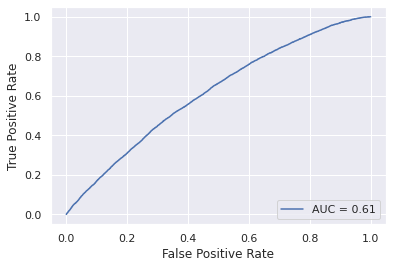

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'roc_auc = {roc_auc.round(3)}')
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

Text(0.5, 1.0, 'Feature Importance')

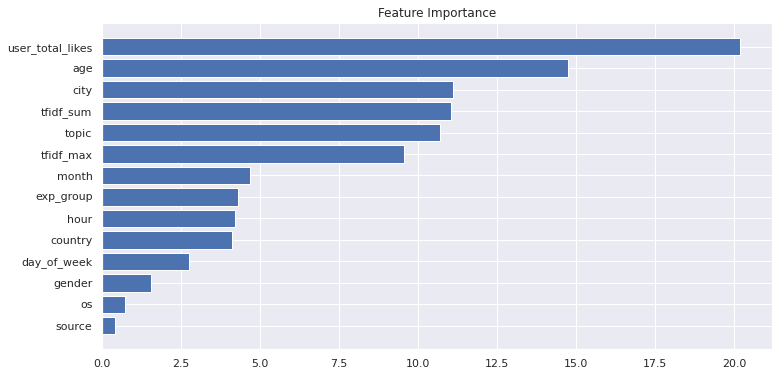

In [46]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [41]:
# Saving model to use it in a service

model.save_model('catboost_model_01', format='cbm')

In [42]:
# Saving TF-IDF features to the database

df_tfidf.to_sql(
   "ignatev_df_tfidf",
    con=conn_uri,
    schema="public",
    if_exists='replace'
   )

23

## Performance Metrics

Performance assessment was implemented in web-based checker using **hitrate@5** metric:

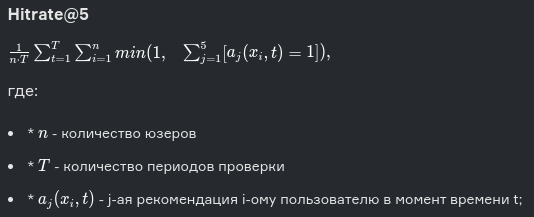

Checker results:

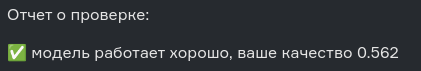